In [1]:
import os
from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Quarters

In [2]:
quarters_path = "./quarters/"
quarters_wrong = glob("./quarters_interesting/*")
quarters_crop = glob("./quarters_cropped/*")

print(f"Successful crop count: {len(quarters_crop)}\nNot successful crop count: {len(quarters_wrong)}")

Successful crop count: 799
Not successful crop count: 451


## 1. Brightness

In [3]:
def compute_brightness(img):
    return np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)).mean()

def make_brightness_df(og_path, crop_folder, img_type):
    brightness = []
    for file in tqdm(crop_folder):
        img_name = file.split('/')[-1]
        img = cv2.imread(f"{og_path}/{img_name}")
        brightness.append(compute_brightness(img))

    brightness_df = pd.DataFrame({"img": crop_folder, "brightness": brightness})
    brightness_df['img'] = brightness_df['img'].apply(lambda x: x.split('/')[-1])
    brightness_df['img_type'] = img_type

    return brightness_df

In [4]:
brightness_correct_df = make_brightness_df(quarters_path, quarters_crop, "Correct Crop")

100%|██████████| 799/799 [00:10<00:00, 73.89it/s] 


In [5]:
brightness_wrong_df = make_brightness_df(quarters_path, quarters_wrong, "Wrong Crop")

100%|██████████| 451/451 [00:07<00:00, 60.66it/s] 


In [6]:
brightness_df = pd.concat([brightness_correct_df, brightness_wrong_df], ignore_index = True)
brightness_df

,img,brightness,img_type
0,Washington Quarter 9 13_2.jpg,178.866686,Correct Crop
1,Washington Quarter 9 14_2.jpg,173.127358,Correct Crop
2,Washington Quarter 9 14_3.jpg,173.505020,Correct Crop
3,Washington Quarter 9 20_0.jpg,174.146733,Correct Crop
4,Washington Quarter 9 20_2.jpg,167.128322,Correct Crop
...,...,...,...
1245,Washington Quarter 219644_132 Reverse.jpg,106.499423,Wrong Crop
1246,Washington Quarter 219644_133 Obverse.jpg,83.482161,Wrong Crop
1247,Washington Quarter 219644_134 Obverse.jpg,119.577126,Wrong Crop
1248,Washington Quarter 219644_135 Obverse.jpg,106.830051,Wrong Crop


In [115]:
brightness_df.to_parquet("./processed_dfs/brightness_df.parquet")

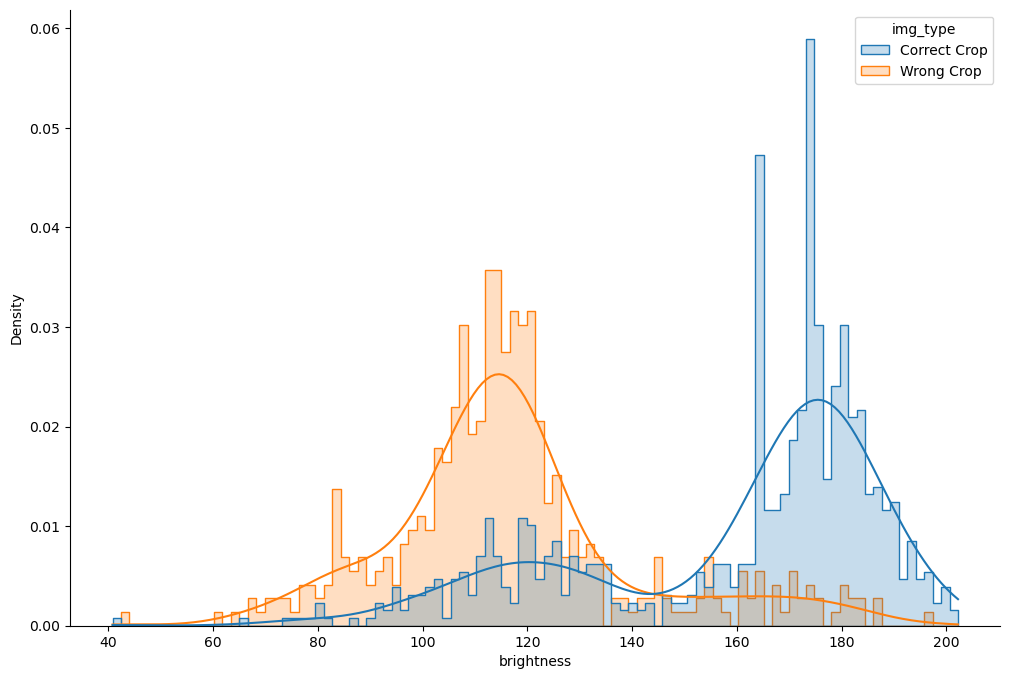

In [7]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(brightness_df, x = "brightness", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax);
ax.spines[['top', 'right']].set_visible(False)

100%|██████████| 451/451 [00:08<00:00, 52.37it/s] 


(1250, 3)


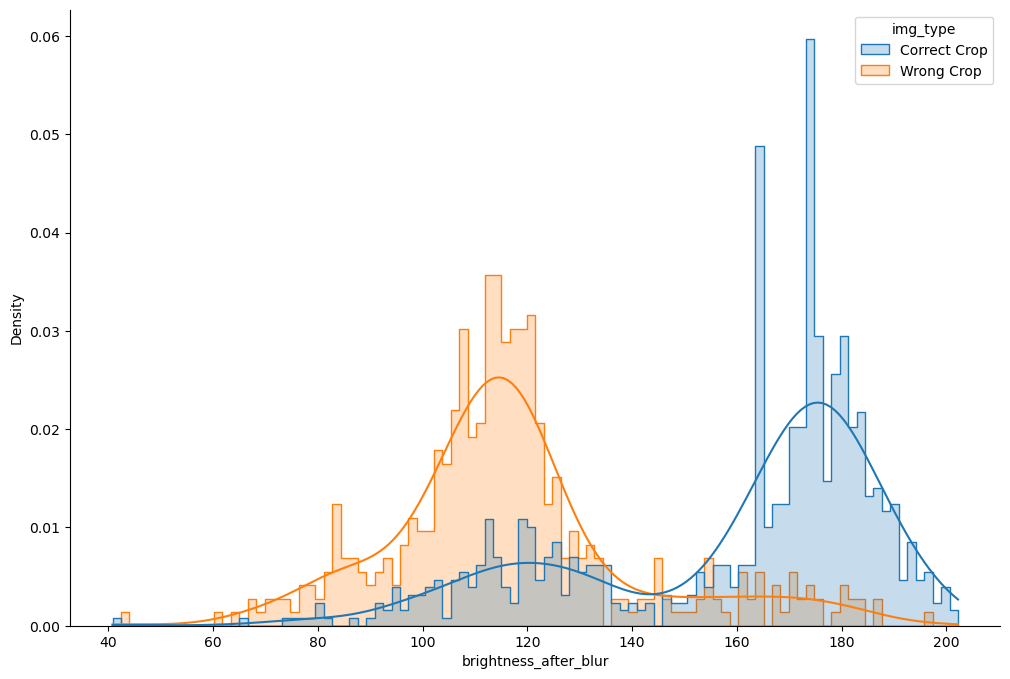

In [43]:
def compute_brightness(img, blur_kernel_size = 15):
    img_blur = cv2.GaussianBlur(img, (blur_kernel_size, blur_kernel_size), 0)
    return np.array(cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)).mean()

def make_brightness_df(og_path, crop_folder, img_type):
    brightness = []
    for file in tqdm(crop_folder):
        img_name = file.split('/')[-1]
        img = cv2.imread(f"{og_path}/{img_name}")
        brightness.append(compute_brightness(img, blur_kernel_size = 15))

    brightness_df = pd.DataFrame({"img": crop_folder, "brightness_after_blur": brightness})
    brightness_df['img'] = brightness_df['img'].apply(lambda x: x.split('/')[-1])
    brightness_df['img_type'] = img_type

    return brightness_df

brightness_correct_df = make_brightness_df(quarters_path, quarters_crop, "Correct Crop")
brightness_wrong_df = make_brightness_df(quarters_path, quarters_wrong, "Wrong Crop")
brightness_df = pd.concat([brightness_correct_df, brightness_wrong_df], ignore_index = True)
print(brightness_df.shape)

fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(brightness_df, x = "brightness_after_blur", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax);
ax.spines[['top', 'right']].set_visible(False)

## 2. Color

### 2.1 Color channel distributions

In [8]:
def make_color_df(og_path, crop_folder, img_type, n):
    red = []
    green = []
    blue = []
    img_path = []
    
    for file in tqdm(crop_folder[:n]):
        img_name = file.split('/')[-1]
        img = Image.open(f"{og_path}/{img_name}")
        img = np.asarray(img)
        h, w, c = img.shape

        red += img[:, :, 0].flatten().tolist()
        green += img[:, :, 1].flatten().tolist()
        blue += img[:, :, 2].flatten().tolist()
        img_path += [img_name] * h * w

    colors_df = pd.DataFrame({"img": img_path, "red": red, "green": green, "blue": blue})
    colors_df['img_type'] = img_type

    return colors_df

In [25]:
colors_correct_df = make_color_df(quarters_path, quarters_crop, "Correct Crop", 3)
colors_correct_df = colors_correct_df[(cbrightness_s_wrong_df[['red', 'green', 'blue']] > 0).any(axis = 1)]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 15.54it/s]


In [26]:
colors_df = pd.concat([colors_correct_df, colors_wrong_df], ignore_index = True)
colors_df.shape

(2504367, 5)

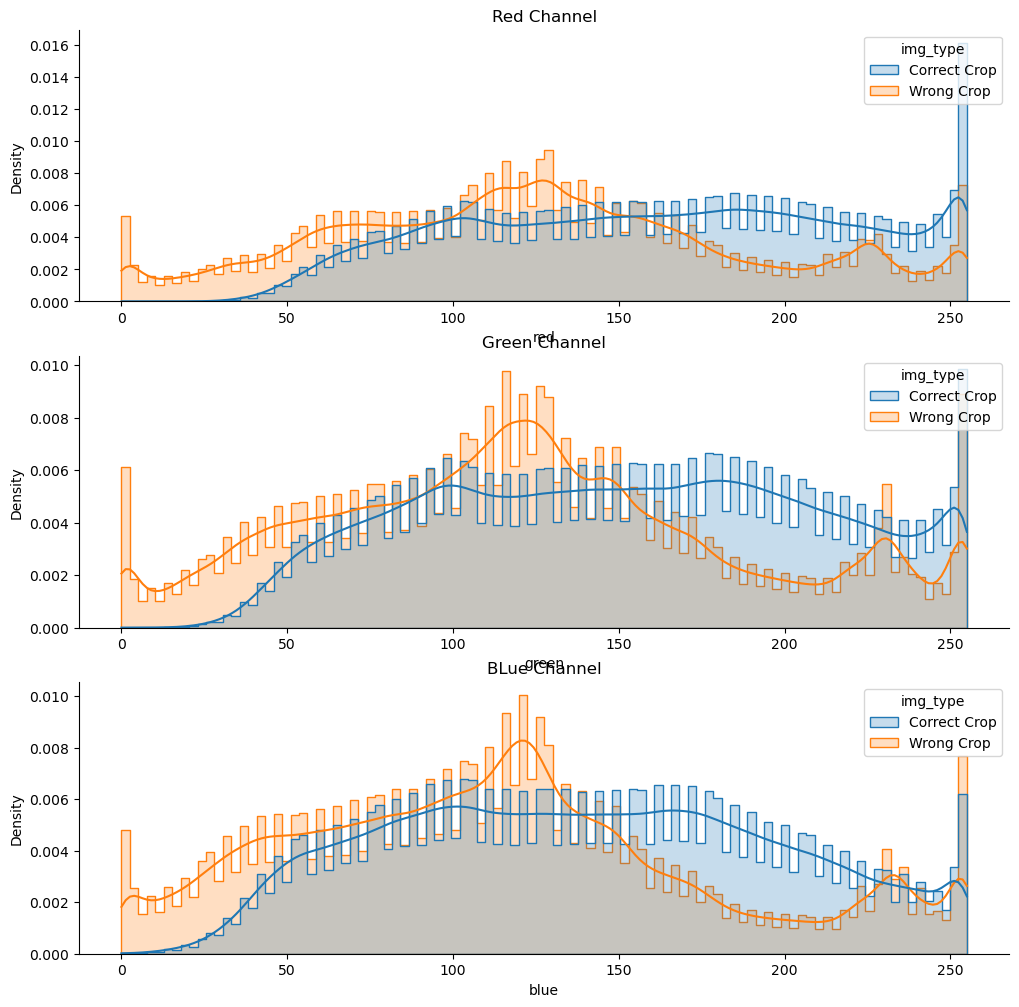

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (12, 12))
sns.histplot(colors_df, x = "red", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax1);
ax1.set_title("Red Channel")

sns.histplot(colors_df, x = "green", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax2);
ax2.set_title("Green Channel")

sns.histplot(colors_df, x = "blue", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax3);
ax3.set_title("BLue Channel")

for ax in (ax1, ax2, ax3):
    ax.spines[['top', 'right']].set_visible(False)

## 3. Contrast

### 3.1 RMS Contrast on Gray-Scale image

In [116]:
def calculate_rms_contrast(image_path):
    gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.sqrt(np.mean((gray_image - np.mean(gray_image))**2))


def make_rms_contast_df(og_path, crop_folder, img_type):
    rms_contrast = []
    for file in tqdm(crop_folder):
        img_name = file.split('/')[-1]
        rms_contrast.append(calculate_rms_contrast(f"{og_path}/{img_name}"))

    rms_contrast_df = pd.DataFrame({"img": crop_folder, "rms_contrast": rms_contrast})
    rms_contrast_df['img'] = rms_contrast_df['img'].apply(lambda x: x.split('/')[-1])
    rms_contrast_df['img_type'] = img_type

    return rms_contrast_df

In [117]:
rms_contrast_correct_df = make_rms_contast_df(quarters_path, quarters_crop, "Correct Crop")
rms_contrast_wrong_df = make_rms_contast_df(quarters_path, quarters_wrong, "Wrong Crop")

rms_contrast_df = pd.concat([rms_contrast_correct_df, rms_contrast_wrong_df], ignore_index = True)
rms_contrast_df.shape

100%|██████████| 451/451 [00:03<00:00, 126.74it/s]


(1250, 3)

In [118]:
rms_contrast_df.to_parquet('./processed_dfs/rms_contrast_df.parquet')

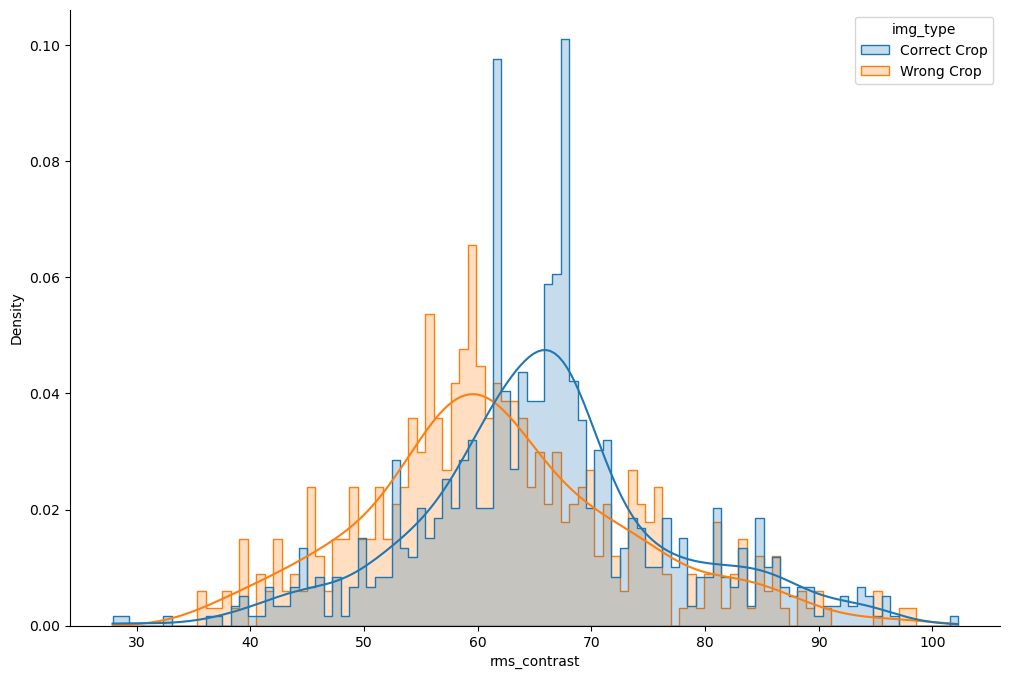

In [119]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(rms_contrast_df, x = "rms_contrast", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax);
ax.spines[['top', 'right']].set_visible(False)

### 3.2 RMS Contrast on Gaussian Blur applied Gray-Scale image after

100%|██████████| 451/451 [00:04<00:00, 103.90it/s]


(1250, 3)


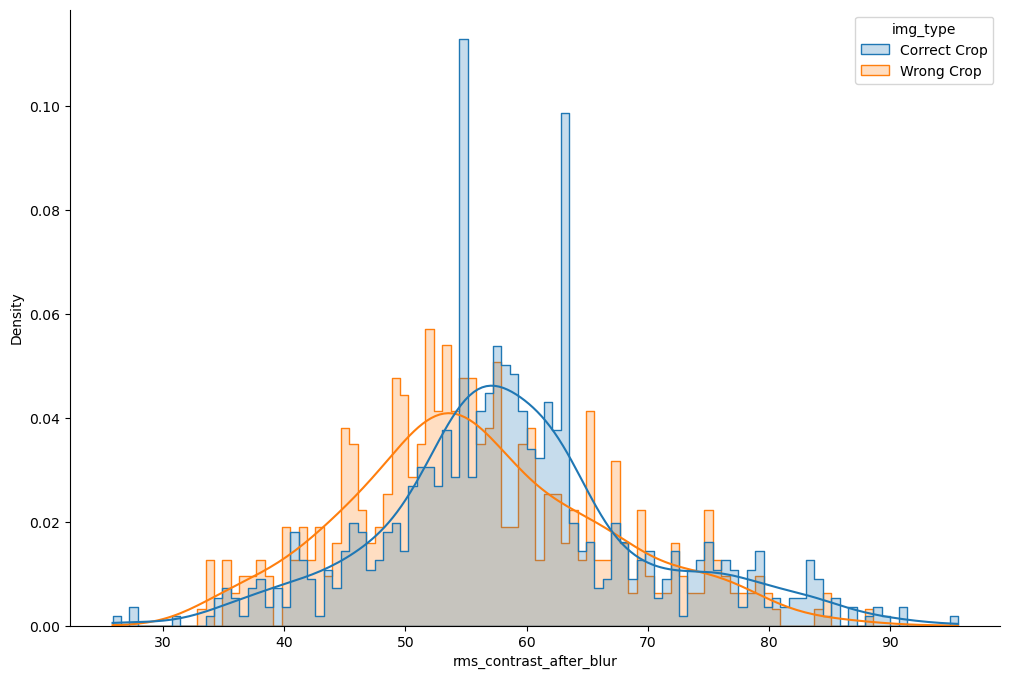

In [120]:
# After applying Gaussian blur
def calculate_rms_contrast(image_path, blur_kernel_size = 15):
    gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_blur = cv2.GaussianBlur(gray_image, (blur_kernel_size, blur_kernel_size), 0)
    return np.sqrt(np.mean((img_blur - np.mean(img_blur))**2))


def make_rms_contast_df(og_path, crop_folder, img_type):
    rms_contrast = []
    for file in tqdm(crop_folder):
        img_name = file.split('/')[-1]
        rms_contrast.append(calculate_rms_contrast(f"{og_path}/{img_name}"))

    rms_contrast_df = pd.DataFrame({"img": crop_folder, "rms_contrast_after_blur": rms_contrast})
    rms_contrast_df['img'] = rms_contrast_df['img'].apply(lambda x: x.split('/')[-1])
    rms_contrast_df['img_type'] = img_type

    return rms_contrast_df

rms_contrast_correct_df = make_rms_contast_df(quarters_path, quarters_crop, "Correct Crop")
rms_contrast_wrong_df = make_rms_contast_df(quarters_path, quarters_wrong, "Wrong Crop")

rms_contrast_df = pd.concat([rms_contrast_correct_df, rms_contrast_wrong_df], ignore_index = True)
print(rms_contrast_df.shape)

fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(rms_contrast_df, x = "rms_contrast_after_blur", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax);
ax.spines[['top', 'right']].set_visible(False)

In [121]:
rms_contrast_df.to_parquet('./processed_dfs/rms_contrast_df_blurred.parquet')

### 3.3 Convert image to YUV and calculate Michelson on Y

In [32]:
def make_michelson_contrast_df(og_path, crop_folder, img_type):
    michelson_contrast = []

    for file in tqdm(crop_folder):
        img_name = file.split('/')[-1]
        img = cv2.imread(f"{og_path}/{img_name}")
        Y = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)[:, :, 0]
        min_int = np.min(Y)
        max_int = np.max(Y)
        michelson_contrast.append((max_int - min_int)/(max_int + min_int))

    michelson_contrast_df = pd.DataFrame({"img": crop_folder, "michelson_contrast": michelson_contrast})
    michelson_contrast_df['img'] = michelson_contrast_df['img'].apply(lambda x: x.split('/')[-1])
    michelson_contrast_df['img_type'] = img_type

    return michelson_contrast_df

michelson_contrast_correct_df = make_michelson_contrast_df(quarters_path, quarters_crop, "Correct Crop")
michelson_contrast_wrong_df = make_michelson_contrast_df(quarters_path, quarters_wrong, "Wrong Crop")

michelson_contrast_df = pd.concat([michelson_contrast_correct_df, michelson_contrast_wrong_df], ignore_index = True)
michelson_contrast_df.shape

100%|██████████| 451/451 [00:09<00:00, 45.82it/s]


(1250, 3)

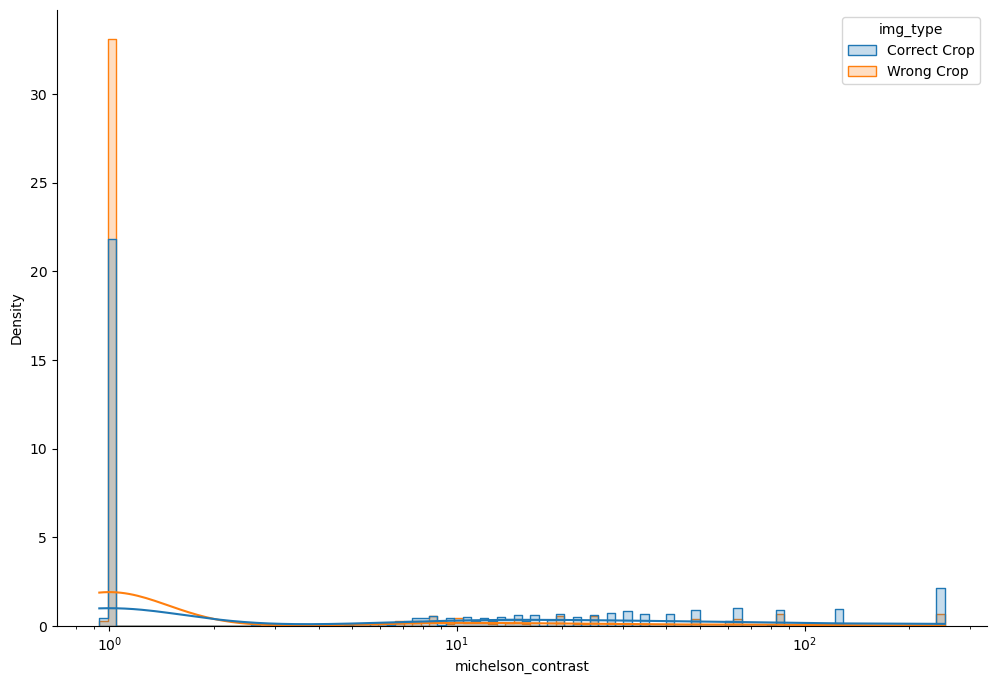

In [34]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(michelson_contrast_df, x = "michelson_contrast", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax);
ax.spines[['top', 'right']].set_visible(False)

### 3.4 Mean michelson contrast each color channel (RGB)

100%|██████████| 451/451 [00:07<00:00, 62.35it/s] 


(1250, 3)


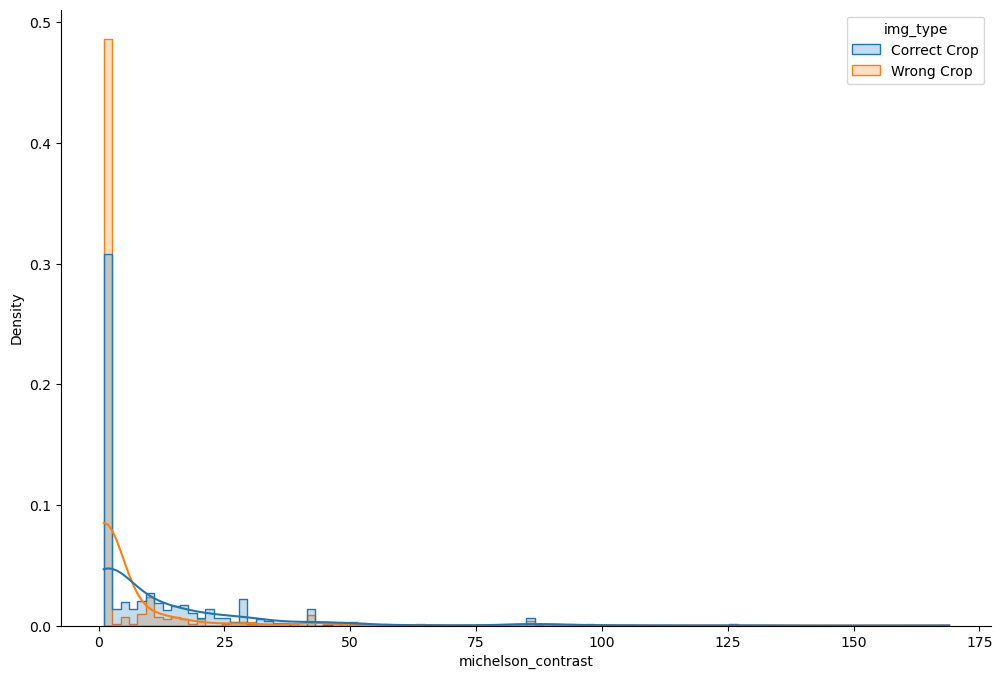

In [35]:
def make_michelson_contrast_df(og_path, crop_folder, img_type):
    michelson_contrast = []

    for file in tqdm(crop_folder):
        img_name = file.split('/')[-1]
        img = np.asarray(Image.open(f"{og_path}/{img_name}"))

        contrast_blue = (np.max(img[:, :, 2]) - np.min(img[:, :, 2])) / (np.max(img[:, :, 2]) + np.min(img[:, :, 2]))
        contrast_green = (np.max(img[:, :, 1]) - np.min(img[:, :, 1])) / (np.max(img[:, :, 1]) + np.min(img[:, :, 1]))
        contrast_red = (np.max(img[:, :, 0]) - np.min(img[:, :, 0])) / (np.max(img[:, :, 0]) + np.min(img[:, :, 0]))

        overall_contrast = (contrast_red + contrast_green + contrast_blue) / 3
        michelson_contrast.append(overall_contrast)

    michelson_contrast_df = pd.DataFrame({"img": crop_folder, "michelson_contrast": michelson_contrast})
    michelson_contrast_df['img'] = michelson_contrast_df['img'].apply(lambda x: x.split('/')[-1])
    michelson_contrast_df['img_type'] = img_type

    return michelson_contrast_df

michelson_contrast_correct_df = make_michelson_contrast_df(quarters_path, quarters_crop, "Correct Crop")
michelson_contrast_wrong_df = make_michelson_contrast_df(quarters_path, quarters_wrong, "Wrong Cromichelson_contrastp")

michelson_contrast_df = pd.concat([michelson_contrast_correct_df, michelson_contrast_wrong_df], ignore_index = True)
print(michelson_contrast_df.shape)

fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(michelson_contrast_df, x = "michelson_contrast", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax);
ax.spines[['top', 'right']].set_visible(False)

### 3.5 Mean of michelson contrast calculated on each RGB channel after applying CLAHE to image

In [37]:
def calculate_michelson_contrast_clahe(img, clip_limit = 2.0, grid_size = (8, 8)):
    # Convert the image to LAB color space
    lab_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    # Extract the L channel
    l_channel = lab_image[:, :, 0]

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit = clip_limit, tileGridSize = grid_size)
    clahe_l_channel = clahe.apply(l_channel)

    # Replace the original L channel with the CLAHE-enhanced L channel
    lab_image[:, :, 0] = clahe_l_channel

    # Convert the image back to RGB color space
    clahe_rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    # Normalize pixel values to [0, 1]
    normalized_image = clahe_rgb_image.astype(float) / 255.0

    # Calculate the Michelson contrast for each color channel
    contrast_red = (np.max(normalized_image[:, :, 0]) - np.min(normalized_image[:, :, 0])) / (np.max(normalized_image[:, :, 0]) + np.min(normalized_image[:, :, 0]))
    contrast_green = (np.max(normalized_image[:, :, 1]) - np.min(normalized_image[:, :, 1])) / (np.max(normalized_image[:, :, 1]) + np.min(normalized_image[:, :, 1]))
    contrast_blue = (np.max(normalized_image[:, :, 2]) - np.min(normalized_image[:, :, 2])) / (np.max(normalized_image[:, :, 2]) + np.min(normalized_image[:, :, 2]))

    # Calculate the overall Michelson contrast
    overall_contrast = (contrast_red + contrast_green + contrast_blue) / 3
    return overall_contrast

def make_michelson_contrast_clahe_df(og_path, crop_folder, img_type):
    michelson_contrast_clahe = []

    for file in tqdm(crop_folder):
        img_name = os.path.basename(file)
        img = np.asarray(Image.open(os.path.join(og_path, img_name)))

        # Calculate Michelson contrast after CLAHE
        overall_contrast_clahe = calculate_michelson_contrast_clahe(img)
        michelson_contrast_clahe.append(overall_contrast_clahe)

    michelson_contrast_clahe_df = pd.DataFrame({"img": crop_folder, "michelson_contrast_clahe": michelson_contrast_clahe})
    michelson_contrast_clahe_df['img'] = michelson_contrast_clahe_df['img'].apply(lambda x: os.path.basename(x))
    michelson_contrast_clahe_df['img_type'] = img_type

    return michelson_contrast_clahe_df

michelson_contrast_correct_df = make_michelson_contrast_clahe_df(quarters_path, quarters_crop, "Correct Crop")
michelson_contrast_wrong_df = make_michelson_contrast_clahe_df(quarters_path, quarters_wrong, "Wrong Crop")

michelson_contrast_df = pd.concat([michelson_contrast_correct_df, michelson_contrast_wrong_df], ignore_index = True)
print(michelson_contrast_df.shape)


  0%|          | 0/799 [00:00<?, ?it/s]

100%|██████████| 451/451 [00:16<00:00, 26.58it/s]

(1250, 3)


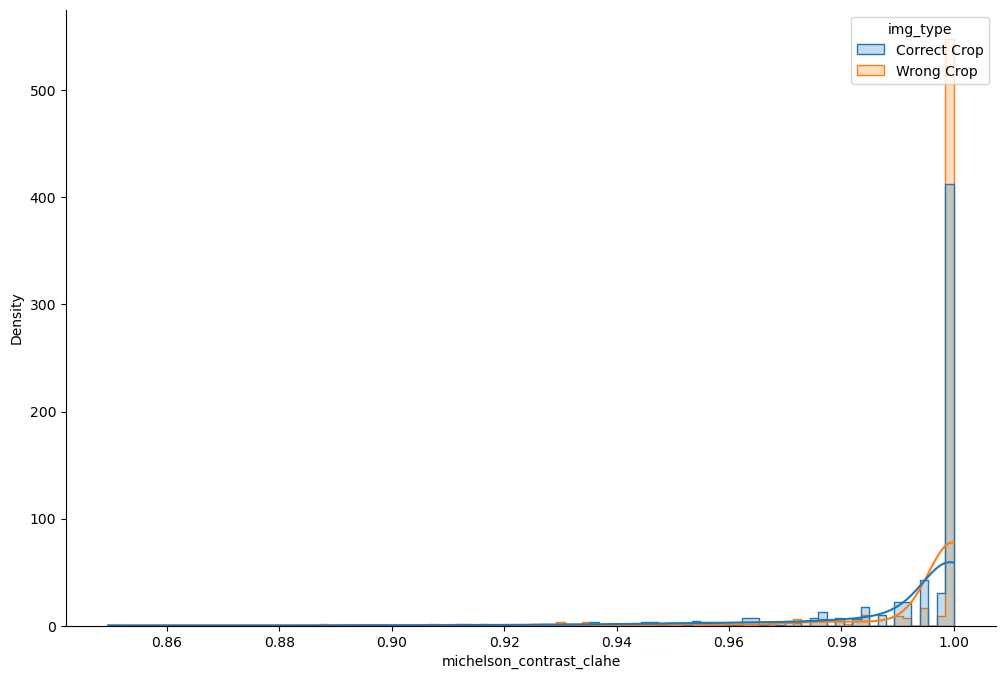

In [40]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(michelson_contrast_df, x = "michelson_contrast_clahe", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax);
ax.spines[['top', 'right']].set_visible(False)

### 3.6 Weber Contrast

In [82]:
def background_intensity(img, blurred, dp = 1, minDist = 50, param1 = 50, param2 = 30, minRadius = 20):
    h, w = blurred.shape
    circles = cv2.HoughCircles(blurred,
                               cv2.HOUGH_GRADIENT,
                               dp = dp, 
                               minDist = minDist,
                               param1 = param1,
                               param2 = param2,
                               minRadius = minRadius,
                               maxRadius = max(int(h/2), int(w/2)))
    
    circles = np.round(circles[0, :]).astype("int")
    valid_circles = [circle for circle in circles if circle[2] > 30]
    best_circle = max(valid_circles, key = lambda x: x[2])

    x, y, r = best_circle

    mask = np.ones_like(img, dtype = 'uint8')
    cv2.circle(mask, (x, y), r, (0, 0, 0), -1)
    mask_1 = mask[:, :, 0]

    background = cv2.bitwise_and(img, img, mask = mask_1)
    background_lab = cv2.cvtColor(background, cv2.COLOR_RGB2LAB)
    
    return background_lab[:, :, 0]

blur_kernel_size = 15

bg_intensity_mean = []
bg_intensity_median = []
bg_intensity_std = []
bg_intensity_skewness = []
bg_intensity_kurtosis = []

for file in tqdm(quarters_crop):
    img_name = os.path.basename(file)
    img = np.asarray(Image.open(os.path.join(quarters_path, img_name)))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_img, (blur_kernel_size, blur_kernel_size), 0)

    bg_lab = background_intensity(img, blurred)
    
    bg_lab_mean = np.mean(bg_lab)
    bg_lab_median = np.median(bg_lab)
    bg_lab_std = np.std(bg_lab)
    bg_lab_skew = np.mean((bg_lab - bg_lab_mean) ** 3) / (bg_lab_std ** 3)
    bg_lab_kurtosis = np.mean((bg_lab - bg_lab_mean) ** 4) / (bg_lab_std ** 4) - 3

    bg_intensity_mean.append(bg_lab_mean)
    bg_intensity_median.append(bg_lab_median)
    bg_intensity_std.append(bg_lab_std)
    bg_intensity_skewness.append(bg_lab_skew)
    bg_intensity_kurtosis.append(bg_lab_kurtosis)

100%|██████████| 799/799 [11:19<00:00,  1.18it/s]


In [83]:
correctly_cropped_quarter_bg_df = pd.DataFrame({"img": quarters_crop, 
                                                "background_lightness_mean": bg_intensity_mean,
                                                "background_lightness_median": bg_intensity_median,
                                                "background_lightness_std": bg_intensity_std,
                                                "background_lightness_skewness": bg_intensity_skewness,
                                                "background_lightness_kurtosis": bg_intensity_kurtosis})
correctly_cropped_quarter_bg_df.to_parquet("./processed_dfs/correctly_cropped_quarter_bg_df.parquet")

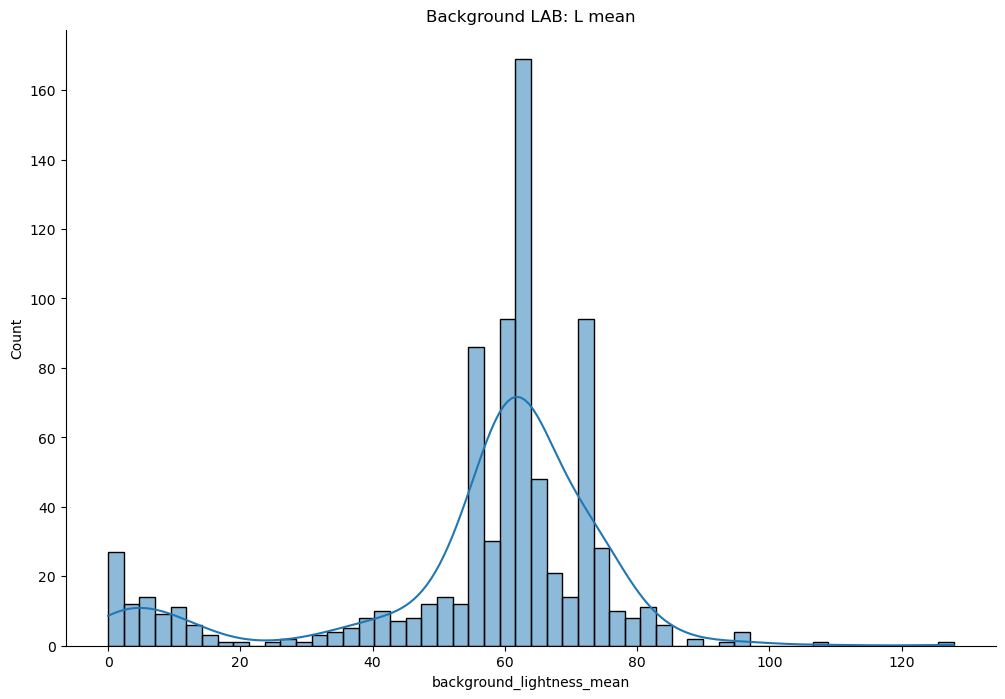

In [98]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(correctly_cropped_quarter_bg_df, x = "background_lightness_mean", kde = True, ax = ax);
ax.spines[['top', 'right']].set_visible(False)
ax.set_title("Background LAB: L mean");

Text(0.5, 1.0, 'Background LAB: L median')

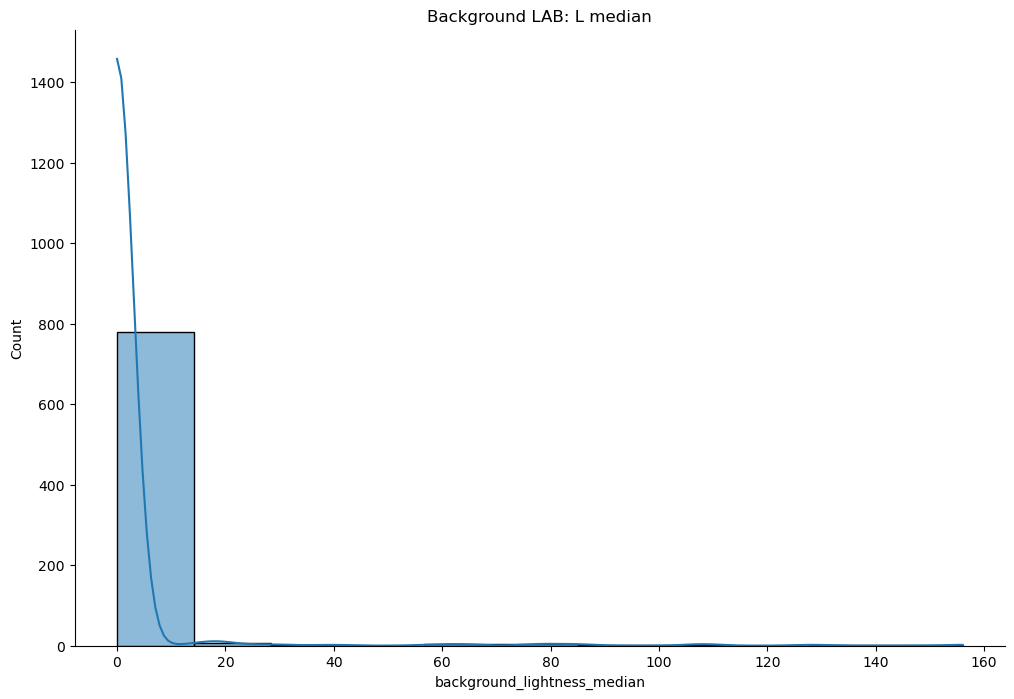

In [96]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(correctly_cropped_quarter_bg_df, x = "background_lightness_median", kde = True, ax = ax);
ax.spines[['top', 'right']].set_visible(False)
ax.set_title("Background LAB: L median")

Text(0.5, 1.0, 'Background LAB: L std')

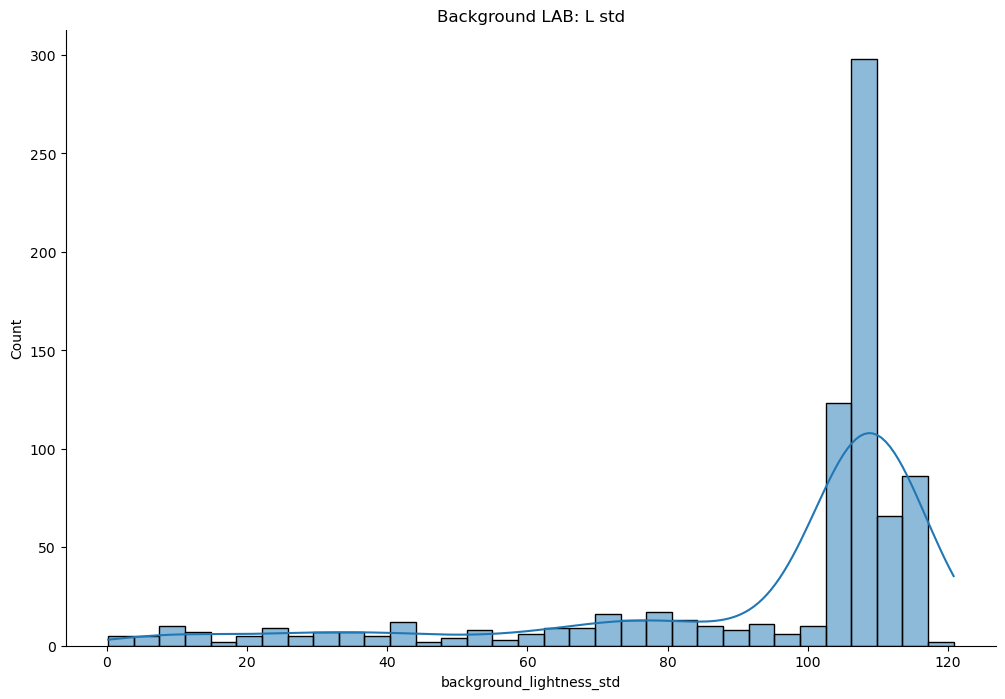

In [94]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(correctly_cropped_quarter_bg_df, x = "background_lightness_std", kde = True, ax = ax);
ax.spines[['top', 'right']].set_visible(False)
ax.set_title("Background LAB: L std")

Text(0.5, 1.0, 'Background LAB: L skewness')

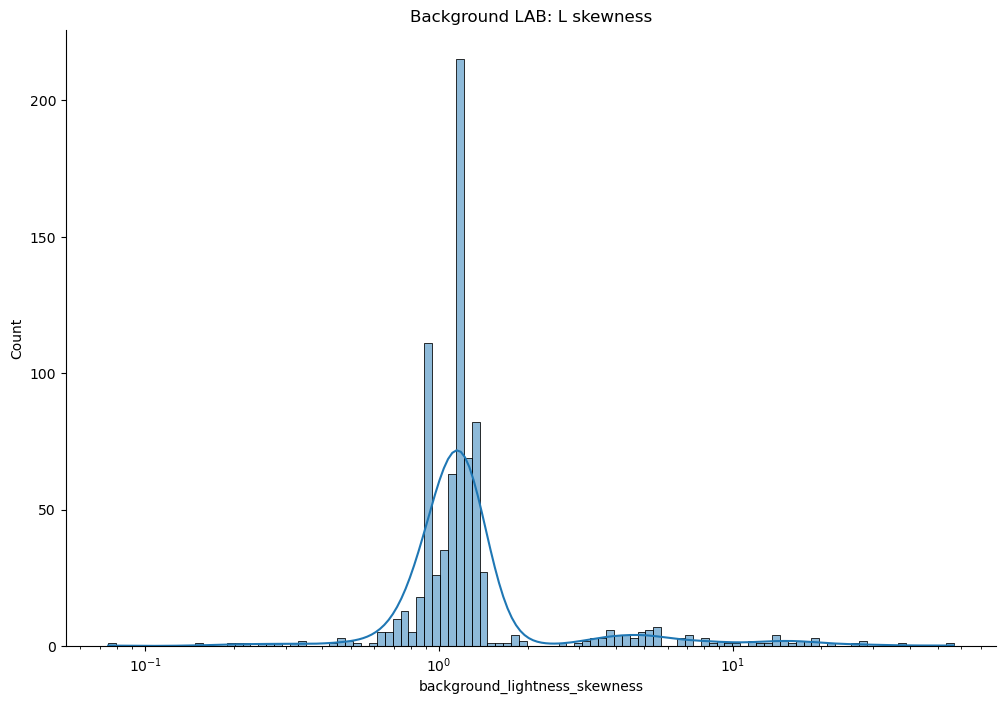

In [91]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(correctly_cropped_quarter_bg_df, x = "background_lightness_skewness", kde = True, log_scale = True, ax = ax);
ax.spines[['top', 'right']].set_visible(False)
ax.set_title("Background LAB: L skewness")

Text(0.5, 1.0, 'Background LAB: L kurtosis')

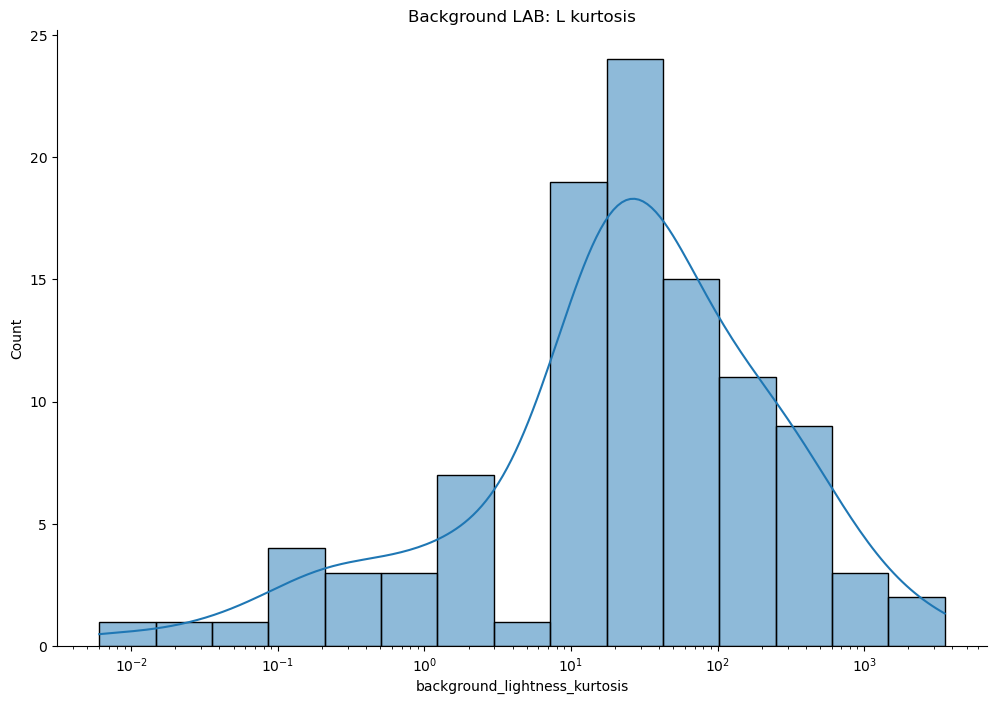

In [92]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(correctly_cropped_quarter_bg_df, x = "background_lightness_kurtosis", kde = True, log_scale = True, ax = ax);
ax.spines[['top', 'right']].set_visible(False)
ax.set_title("Background LAB: L kurtosis")

In [104]:
def calculate_weber_contrast(img, background_intensity = 0):
    weber_contrast_red = (img[:, :, 0] - background_intensity) / background_intensity
    weber_contrast_green = (img[:, :, 1] - background_intensity) / background_intensity
    weber_contrast_blue = (img[:, :, 2] - background_intensity) / background_intensity

    # Calculate the overall Weber contrast
    overall_weber_contrast = (np.abs(weber_contrast_red) + np.abs(weber_contrast_green) + np.abs(weber_contrast_blue)) / 3
    return np.mean(overall_weber_contrast)

def calc_weber_contrast_df(og_path, crop_folder, img_type, background_intensity = 0):
    weber_contrast = []
    for file in tqdm(crop_folder):
        img_name = os.path.basename(file)
        img = np.asarray(Image.open(os.path.join(og_path, img_name)))

        overall_weber_contrast = calculate_weber_contrast(img, background_intensity)
        weber_contrast.append(overall_weber_contrast)

    weber_contrast_df = pd.DataFrame({"img": crop_folder, "weber_contrast": weber_contrast})
    weber_contrast_df['img'] = weber_contrast_df['img'].apply(lambda x: os.path.basename(x))
    weber_contrast_df['img_type'] = img_type

    return weber_contrast_df

In [105]:
background_intensity = correctly_cropped_quarter_bg_df['background_lightness_mean'].mean()
weber_contrast_correct_df = calc_weber_contrast_df(quarters_path, quarters_crop, "Correct Crop", background_intensity)
weber_contrast_wrong_df = calc_weber_contrast_df(quarters_path, quarters_wrong, "Wrong Crop", background_intensity)

weber_contrast_df = pd.concat([weber_contrast_correct_df, weber_contrast_wrong_df], ignore_index = True)
print(weber_contrast_df.shape)

100%|██████████| 451/451 [00:10<00:00, 42.11it/s]

(1250, 3)


In [106]:
weber_contrast_df.to_parquet("./processed_dfs/weber_contrast_df.parquet")

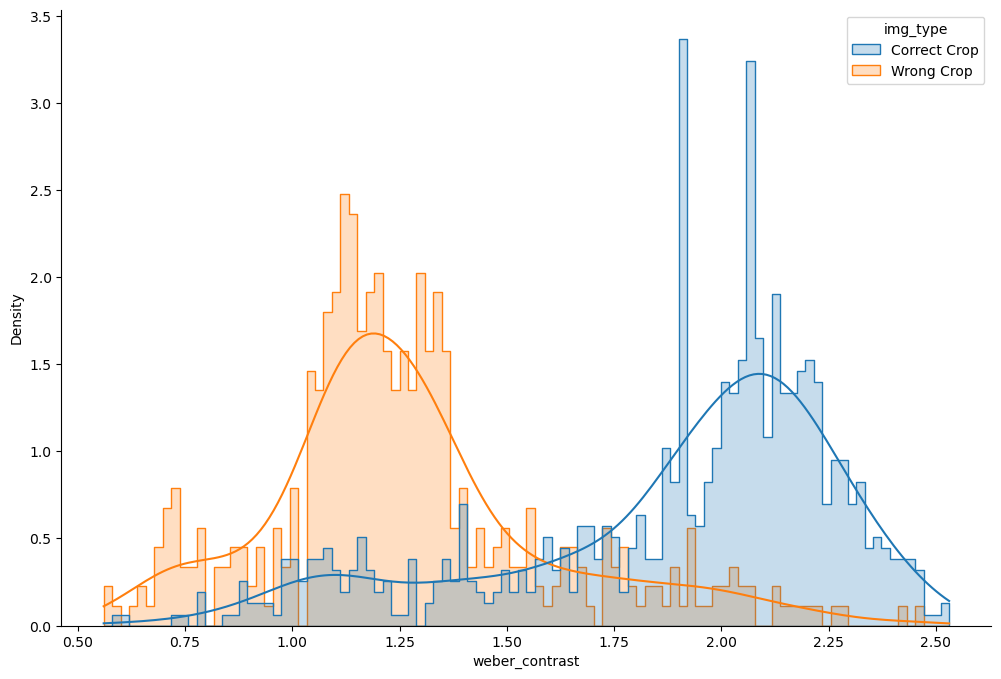

In [107]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(weber_contrast_df, x = "weber_contrast", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax);
ax.spines[['top', 'right']].set_visible(False)

In [108]:
def calc_weber_contrast_df_blurred(og_path, crop_folder, img_type, background_intensity = 0, blur_kernel_size = 15):
    weber_contrast = []
    for file in tqdm(crop_folder):
        img_name = os.path.basename(file)
        img = np.asarray(Image.open(os.path.join(og_path, img_name)))
        img_blur = cv2.GaussianBlur(img, (blur_kernel_size, blur_kernel_size), 0)

        overall_weber_contrast = calculate_weber_contrast(img, background_intensity)
        weber_contrast.append(overall_weber_contrast)

    weber_contrast_df = pd.DataFrame({"img": crop_folder, "weber_contrast_blurred": weber_contrast})
    weber_contrast_df['img'] = weber_contrast_df['img'].apply(lambda x: os.path.basename(x))
    weber_contrast_df['img_type'] = img_type

    return weber_contrast_df

background_intensity = correctly_cropped_quarter_bg_df['background_lightness_mean'].mean()
weber_contrast_correct_df = calc_weber_contrast_df_blurred(quarters_path, quarters_crop, "Correct Crop", background_intensity)
weber_contrast_wrong_df = calc_weber_contrast_df_blurred(quarters_path, quarters_wrong, "Wrong Crop", background_intensity)

weber_contrast_df = pd.concat([weber_contrast_correct_df, weber_contrast_wrong_df], ignore_index = True)
print(weber_contrast_df.shape)

100%|██████████| 451/451 [00:12<00:00, 36.45it/s]

(1250, 3)


In [109]:
weber_contrast_df.to_parquet("./processed_dfs/weber_contrast_df_blurred.parquet")

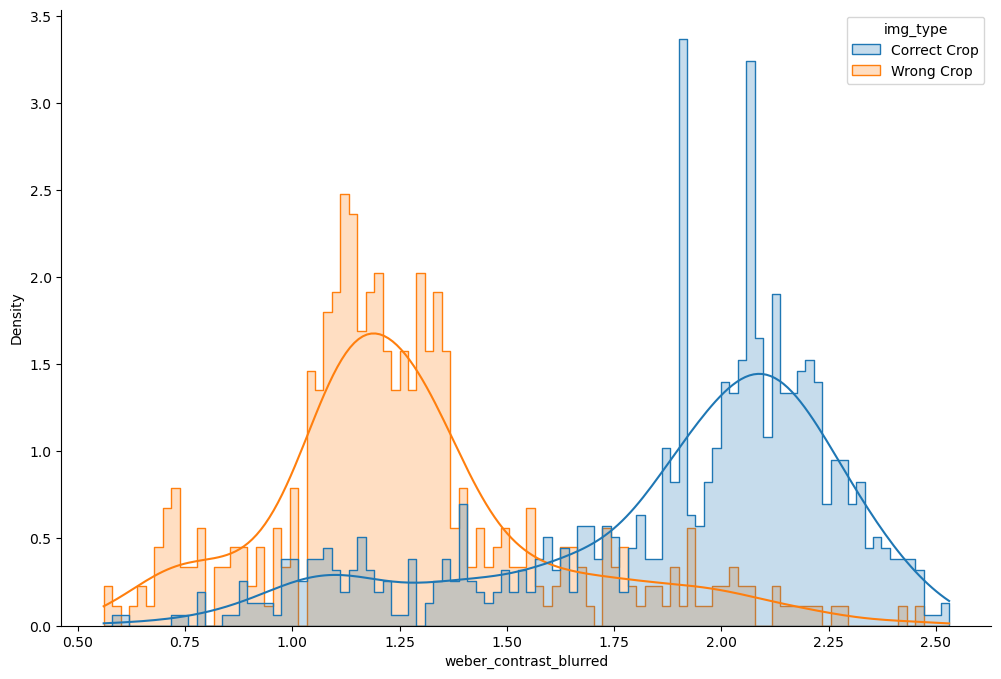

In [113]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(weber_contrast_df, x = "weber_contrast_blurred", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax);
ax.spines[['top', 'right']].set_visible(False)

### 3.7 Contrast to Noise ratio

In [61]:
def calculate_cnr(img, background_intensity = 0):
    mean_signal = np.mean(img)
    mean_background = background_intensity
    std_background = np.std(img)

    cnr = (mean_signal - mean_background) / std_background
    return cnr

def calc_cnr_values_df(og_path, crop_folder, img_type, background_intensity = 0):
    cnr_values = []

    for file in tqdm(crop_folder):
        img_name = os.path.basename(file)
        img = np.asarray(Image.open(os.path.join(og_path, img_name)))

        cnr = calculate_cnr(img, background_intensity)
        cnr_values.append(cnr)

    cnr_values_df = pd.DataFrame({"img": crop_folder, "cnr": cnr_values})
    cnr_values_df['img'] = cnr_values_df['img'].apply(lambda x: x.split('/')[-1])
    cnr_values_df['img_type'] = img_type

    return cnr_values_df

In [62]:
cnr_values_correct_df = calc_cnr_values_df(quarters_path, quarters_crop, "Correct Crop")
cnr_values_wrong_df = calc_cnr_values_df(quarters_path, quarters_wrong, "Wrong Crop")

cnr_values_df = pd.concat([cnr_values_correct_df, cnr_values_wrong_df], ignore_index = True)
print(cnr_values_df.shape)

100%|██████████| 451/451 [00:09<00:00, 49.25it/s] 

(1250, 3)


In [ ]:
cnr_values_df.to_parquet("./processed_dfs/cnr_values_df.parquet")

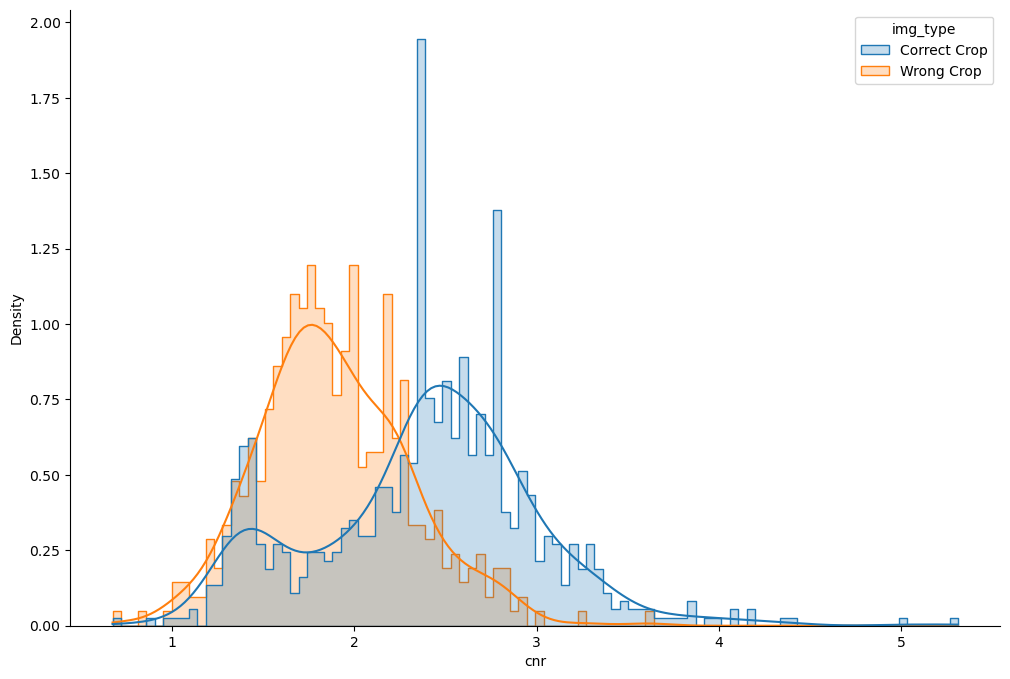

In [63]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(cnr_values_df, x = "cnr", hue = "img_type", 
             common_norm = False, bins = 100, element = 'step', stat = 'density', kde = True,
             ax = ax);
ax.spines[['top', 'right']].set_visible(False)